Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking, CmdStan, StanMCMCChain, LinearAlgebra
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "04")
cd(ProjDir)

### snippet 4.7

In [3]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df);
first(df2, 5)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0


Use data from m4.1s

Check if the m4.1s.jls file is present. If not, run the model.

In [5]:
!isfile(joinpath(ProjDir, "m4.1s.jls")) && include(joinpath(ProjDir, "m4.1s.jl"))

chn = deserialize(joinpath(ProjDir, "m4.1s.jls"))

Object of type "Chains{Float64}"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Union{Missing, Float64}[7.81224 154.568; 7.38153 154.456; … ; 7.91943 154.147; 7.84226 154.008]

Union{Missing, Float64}[7.93397 153.716; 7.8548 154.23; … ; 7.68105 154.969; 7.77152 154.596]

Union{Missing, Float64}[7.43228 154.703; 7.36335 154.763; … ; 7.32925 154.933; 7.32925 154.933]

Union{Missing, Float64}[7.71488 154.579; 7.78205 154.722; … ; 8.05554 154.656; 7.74677 154.339]

Describe the draws

In [6]:
describe(chn)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
         Mean        SD       Naive SE      MCSE      ESS
sigma   7.758106 0.29420915 0.004651855 0.0055192555 1000
   mu 154.594682 0.41395793 0.006545250 0.0072986866 1000

Quantiles:
         2.5%       25.0%      50.0%      75.0%      97.5%  
sigma   7.203489   7.557105   7.742135   7.947325   8.380646
   mu 153.769000 154.334000 154.596000 154.868000 155.392000



Plot the density of posterior draws

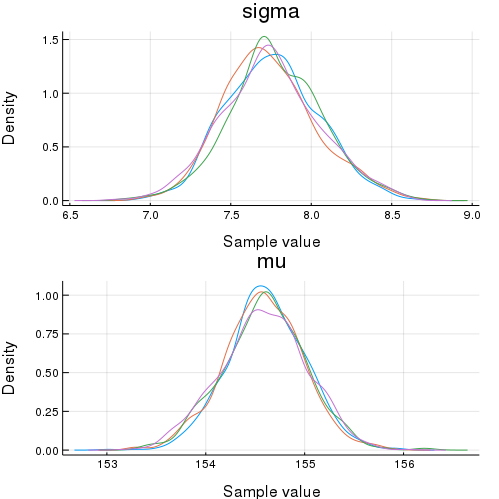

In [7]:
density(chn, lab="All heights", xlab="height [cm]", ylab="density")

Compute cor

In [8]:
mu_sigma = hcat(chn.value[:, 2, 1], chn.value[:,1, 1])
LinearAlgebra.diag(cov(mu_sigma))

2-element Array{Float64,1}:
 0.1536628837227226
 0.0818788530303804

Compute cov

In [9]:
cor(mu_sigma)

2×2 Array{Float64,2}:
 1.0         0.00230199
 0.00230199  1.0       

End of `clip_07.0s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*